## Load Libraries

In [ ]:
# 1. Install pyTextRank and its dependency, graphviz (required for visualization and some core functions)
!pip install pytextrank graphviz

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pytextrank
import nltk
import re

/usr/local/lib/python3.12/dist-packages


Load Data

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Data/newsData/raw_analyst_ratings.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/newsData/raw_analyst_ratings.csv')

In [ ]:
df.head(5)

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


In [ ]:
#check missing
df.isna().sum()

,0
Unnamed: 0,0
headline,0
url,0
publisher,0
date,0
stock,0


## 1. Descriptive Statistics
---

### 1.1 Headline Length

In [ ]:
df['headline_length'] = df['headline'].apply(lambda x: len(str(x).split()))

In [ ]:
print("\n--- Headline Word Length Statistics ---")
print(df['headline_length'].describe())


--- Headline Word Length Statistics ---
count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_length, dtype: float64


Text(0, 0.5, 'Frequency')

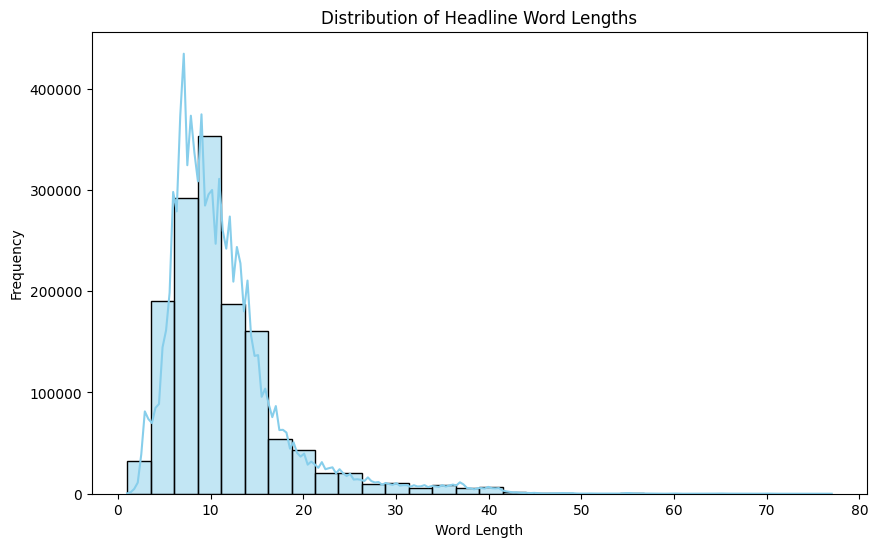

In [ ]:
#Visualization: Histogram of Text Length
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Headline Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')

### 1.2 Articles Per Publisher & Most Active Publisher

In [ ]:
#Articles Per Publisher
publisher_counts = df['publisher'].value_counts().reset_index()
publisher_counts.columns = ['publisher', 'article_count']

In [ ]:
#Top 10 Most Active Publishers
publisher_counts.columns = ['publisher', 'article_count']
top_10_publishers = publisher_counts.head(10)

print(f"\n--- Top 10 Most Active Publishers ({len(publisher_counts)} total unique publishers) ---")
print(top_10_publishers)


--- Top 10 Most Active Publishers (1034 total unique publishers) ---
           publisher  article_count
0      Paul Quintaro         228373
1         Lisa Levin         186979
2  Benzinga Newsdesk         150484
3      Charles Gross          96732
4      Monica Gerson          82380
5       Eddie Staley          57254
6         Hal Lindon          49047
7      ETF Professor          28489
8         Juan Lopez          28438
9     Benzinga Staff          28114


/tmp/ipython-input-1637732929.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='article_count', y='publisher', data=top_10_publishers, palette='viridis')


Text(0, 0.5, 'Publisher')

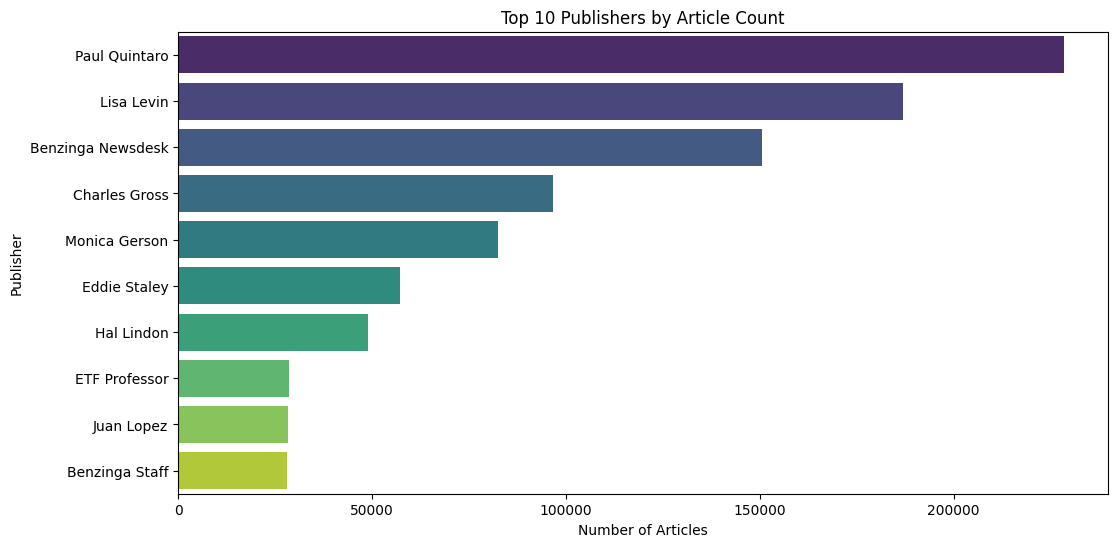

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='article_count', y='publisher', data=top_10_publishers, palette='viridis')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Publisher')

### 1.3 Publication Date Trends

In [ ]:

#Change data type from object to datetime using format ISO8601
df['date'] = pd.to_datetime(df['date'], format='ISO8601', utc = True)
print(df['date'].head())
print(f"Data type is now: {df['date'].dtype}")

0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
Data type is now: datetime64[ns, UTC]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   Unnamed: 0       1407328 non-null  int64              
 1   headline         1407328 non-null  object             
 2   url              1407328 non-null  object             
 3   publisher        1407328 non-null  object             
 4   date             1407328 non-null  datetime64[ns, UTC]
 5   stock            1407328 non-null  object             
 6   headline_length  1407328 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 75.2+ MB



--- Article Count by Day of the Week ---
day_of_week
Monday       265139
Tuesday      296505
Wednesday    300922
Thursday     302619
Friday       217918
Saturday       7759
Sunday        16466
Name: count, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

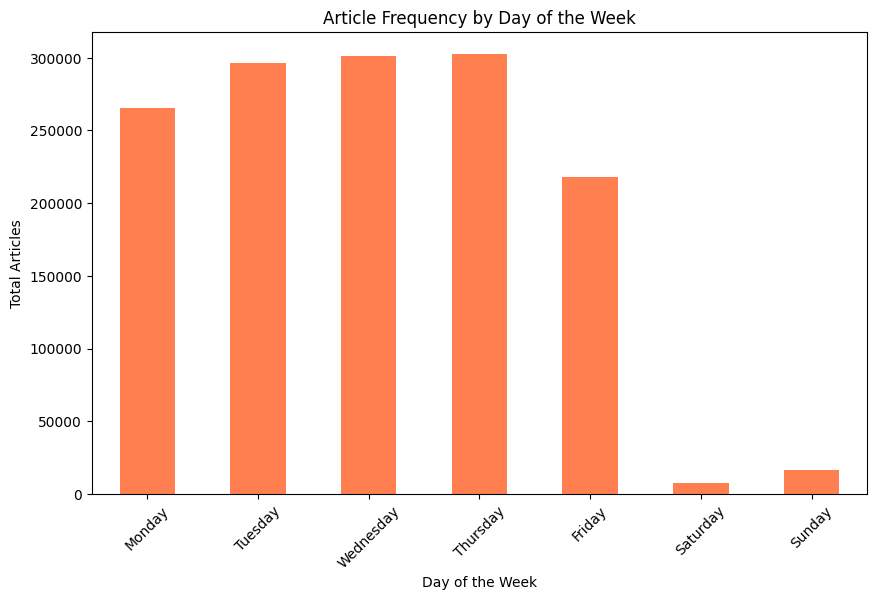

In [ ]:

# Analyze News Frequency by Day of the Week
df['day_of_week'] = df['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = df['day_of_week'].value_counts().reindex(day_order)
print("\n--- Article Count by Day of the Week ---")
print(daily_counts)

# Visualization: Frequency by Day of Week
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar', color='coral')
plt.title('Article Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Articles')
plt.xticks(rotation=45)

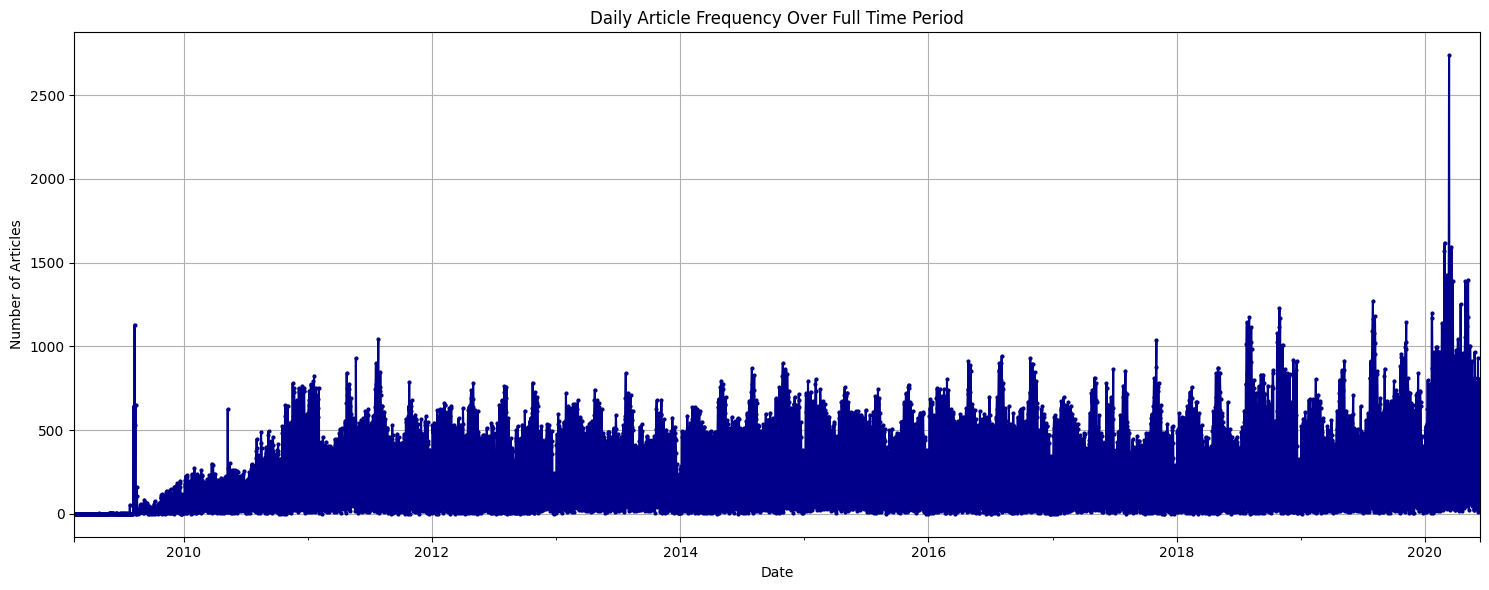

In [ ]:
# Analyze Trend Over Time (Daily Frequency)
daily_trend = df.set_index('date').resample('D').size()

# Visualization: Trend over Time
plt.figure(figsize=(15, 6))
daily_trend.plot(kind='line', marker='o', markersize=2, linestyle='-', color='darkblue')
plt.title('Daily Article Frequency Over Full Time Period')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.tight_layout()

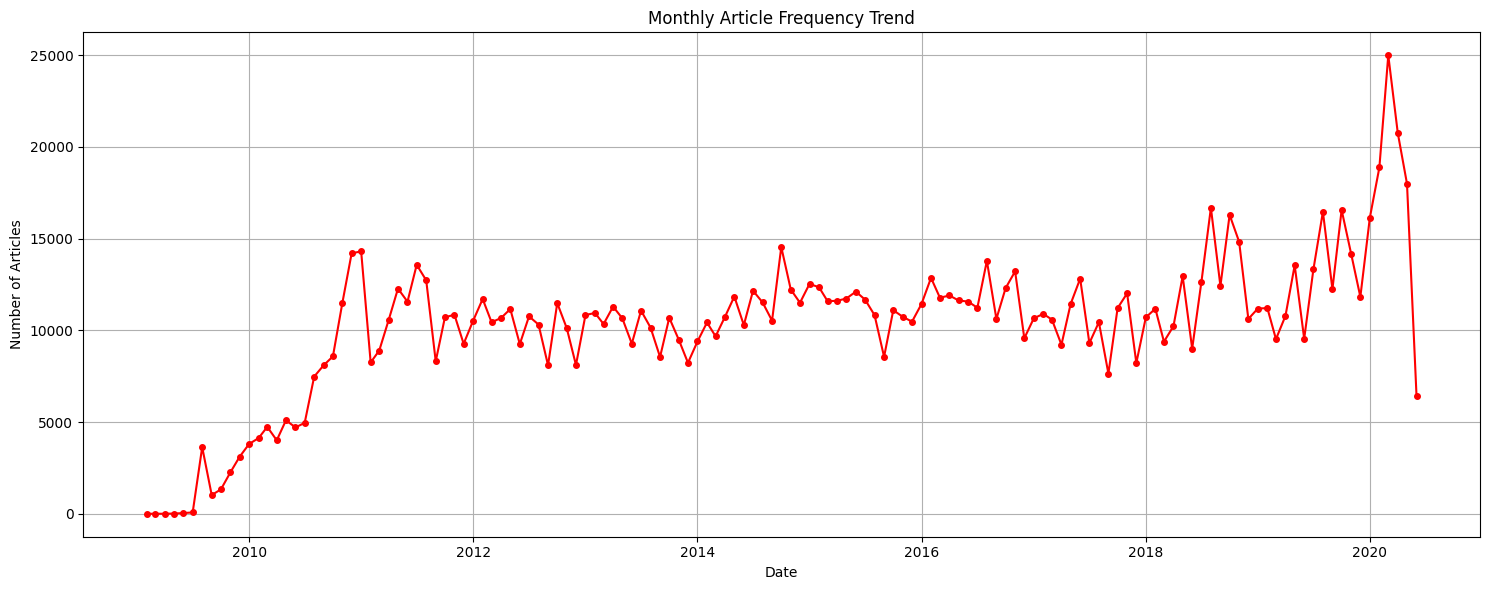

In [ ]:
#Analyze by Month
monthly_trend = df.set_index('date').resample('MS').size()
monthly_trend.name = 'article_count'
monthly_df = monthly_trend.reset_index()

# --- Visualization: Monthly Trend Over Time ---
plt.figure(figsize=(15, 6))
plt.plot(monthly_df['date'], monthly_df['article_count'], marker='o', markersize=4, linestyle='-', color='red')
plt.title('Monthly Article Frequency Trend')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.tight_layout()

## 2. Text Analysis(Topic Modeling)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
# Ensure you have the NLTK resources needed for tokenization
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.download('punkt') # Standard tokenizer for CountVectorizer
except:
    pass

# --- Configuration ---
SAMPLE_SIZE = 50000
N_TOPICS = 10 # Number of topics to discover
RANDOM_STATE = 42
# ---------------------

# Assuming your full DataFrame is loaded as 'df' and has 'headline' and 'date' columns.
df_sample = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)
docs = df_sample['headline'].apply(str).tolist()

print(f"Data successfully sampled down to {len(docs)} headlines.")

Data successfully sampled down to 50000 headlines.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print("Starting Vectorization...")

# Limiting to the top 10,000 most frequent words to control RAM usage
vectorizer = CountVectorizer(
    stop_words='english',
    max_df=0.95, # Ignore terms that appear in too many documents
    min_df=5,    # Ignore terms that appear in too few documents
    max_features=10000 # Critical for memory control
)

# Create the Document-Term Matrix (DTM)
dtm = vectorizer.fit_transform(docs)

print(f"DTM created: {dtm.shape[0]} documents and {dtm.shape[1]} unique terms.")

Starting Vectorization...
DTM created: 50000 documents and 8170 unique terms.


In [ ]:
print("Starting NMF Topic Model Training...")

# Initialize NMF (using 'mu' solver for efficiency)
nmf_model = NMF(
    n_components=N_TOPICS,
    random_state=RANDOM_STATE,
    max_iter=200, # Increased iterations for better convergence
    init='nndsvda', # Recommended initialization for better topic quality
    solver='mu',
    beta_loss='frobenius'
)

# Fit the model to the DTM
nmf_model.fit(dtm)

print("NMF Model Training Complete.")

Starting NMF Topic Model Training...
NMF Model Training Complete.


In [ ]:
# --- 4a: Topic Interpretation ---
feature_names = vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topic_keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_keywords[topic_idx] = top_words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")
    return topic_keywords

print("\n--- Discovered Topics (Top 8 Keywords) ---")
topic_keywords_map = display_topics(nmf_model, feature_names, 8)

# --- 4b: Topic Assignment to Sampled Data ---
# Get the document-topic distribution matrix (H matrix)
doc_topic_matrix = nmf_model.transform(dtm)

# Find the most likely topic for each document
df_sample['nmf_topic_id'] = doc_topic_matrix.argmax(axis=1)

print("\nTopic assignment complete for sampled data.")
print(df_sample[['headline', 'nmf_topic_id']].head())


--- Discovered Topics (Top 8 Keywords) ---
Topic 0: vs, est, eps, reports, sales, revenue, q2, q3
Topic 1: stocks, week, 52, new, session, moving, hit, set
Topic 2: market, update, mid, day, session, moving, markets, morning
Topic 3: pt, 00, buy, raises, announces, maintains, initiates, coverage
Topic 4: shares, trading, companies, higher, lower, oil, amid, following
Topic 5: estimate, sales, eps, beats, adj, beat, q1, miss
Topic 6: earnings, scheduled, february, preview, ahead, 2017, 2019, 2013
Topic 7: price, target, maintains, etfs, lowers, check, pro, raises
Topic 8: alert, option, ask, oi, ref, vs, calls, sweep
Topic 9: benzinga, downgrades, upgrades, 2019, 2018, 2017, pro, neutral

Topic assignment complete for sampled data.
                                            headline  nmf_topic_id
0  Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...             0
1  Mid-Day Market Update: K2M Group Rises On Acqu...             2
2  Aramchol's Failed Past Isn't Its Future; Galme...     

In [ ]:
# --- 5a: Vectorize the FULL Dataset (Memory Warning!) ---
# This is the last high-memory step. We use the *fitted* vectorizer from the sample.
full_docs = df['headline'].apply(str).tolist()
full_dtm = vectorizer.transform(full_docs)

# --- 5b: Transform and Assign to Full DataFrame ---
full_doc_topic_matrix = nmf_model.transform(full_dtm)
df['nmf_topic_id'] = full_doc_topic_matrix.argmax(axis=1)

# --- 5c: Prepare for Time Series Analysis ---
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print("Full DataFrame is ready for Time Series Analysis.")

Full DataFrame is ready for Time Series Analysis.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   Unnamed: 0       1407328 non-null  int64              
 1   headline         1407328 non-null  object             
 2   url              1407328 non-null  object             
 3   publisher        1407328 non-null  object             
 4   date             1407328 non-null  datetime64[ns, UTC]
 5   stock            1407328 non-null  object             
 6   headline_length  1407328 non-null  int64              
 7   day_of_week      1407328 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 85.9+ MB


## 3. Time Series Analysis

In [ ]:
# --- Daily Volume ---
# Resample the entire dataset by Day ('D') and count the number of articles.
daily_counts = df.resample('D').size()

print("\n--- Daily Article Counts (Top 10 Days of News Volume) ---")
print(daily_counts.nlargest(10))


--- Daily Article Counts (Top 10 Days of News Volume) ---
date
2020-03-12 00:00:00+00:00    2739
2020-02-28 00:00:00+00:00    1620
2020-03-19 00:00:00+00:00    1595
2020-02-27 00:00:00+00:00    1567
2020-03-06 00:00:00+00:00    1428
2020-05-07 00:00:00+00:00    1398
2020-03-23 00:00:00+00:00    1391
2020-04-29 00:00:00+00:00    1389
2020-03-11 00:00:00+00:00    1384
2020-04-30 00:00:00+00:00    1327
dtype: int64


In [ ]:
# Group by Day ('D') and the NMF Topic ID, then unstack to get one column per topic.
topic_frequency = df.groupby('nmf_topic_id').resample('D').size().unstack(level='nmf_topic_id', fill_value=0)

# Rename the columns for clarity (optional, but helpful)
# Assuming you have 10 topics (0-9)
topic_frequency.columns = [f'Topic_{c}_Count' for c in topic_frequency.columns]

print("\n--- Daily Frequency of Top 5 Topics (First 7 Days) ---")
# This shows how the volume of different events (like 'Earnings' or 'Analyst Rating') changes daily.
print(topic_frequency.iloc[:7, :5])


--- Daily Frequency of Top 5 Topics (First 7 Days) ---
                           Topic_0_Count  Topic_1_Count  Topic_2_Count  \
date                                                                     
2009-02-14 00:00:00+00:00              0              0              0   
2009-02-15 00:00:00+00:00              0              0              0   
2009-02-16 00:00:00+00:00              0              0              0   
2009-02-17 00:00:00+00:00              0              0              0   
2009-02-18 00:00:00+00:00              0              0              0   
2009-02-19 00:00:00+00:00              0              0              0   
2009-02-20 00:00:00+00:00              0              0              0   

                           Topic_3_Count  Topic_4_Count  
date                                                     
2009-02-14 00:00:00+00:00              0              0  
2009-02-15 00:00:00+00:00              0              0  
2009-02-16 00:00:00+00:00              0     

In [ ]:
# --- Intraday Timing (Hourly Profile) ---
# Since your 'date' column is already timezone-aware (UTC), the hour extraction is accurate.

# Group by the hour of the day (0-23 UTC) and sum up the articles.
intraday_profile = df.groupby(df.index.hour).size()

print("\n--- Hourly News Release Profile (UTC Hours) ---")
print("Hour (0-23 UTC) | Article Count")
print(intraday_profile.nlargest(5))

# --- Topic-Specific Hourly Release Profile ---
# Check when the highest volume of *specific high-impact news* (e.g., Topic 1: Earnings) is released.
# This requires a new grouping by hour and topic.
intraday_topic_profile = df.groupby([df.index.hour, 'nmf_topic_id']).size().unstack(level='nmf_topic_id', fill_value=0)

# Analyze the hourly release profile for Topic 1 (Example)
if 1 in intraday_topic_profile.columns:
    topic_1_hourly_profile = intraday_topic_profile[1]
    print("\n--- Topic 1 Hourly Release Profile (Top 5 Hours) ---")
    print(topic_1_hourly_profile.nlargest(5))

# **Crucial Insight:** Convert UTC time to ET (NYC/Toronto trading time). For example, 12:00 UTC is 8:00 AM ET (before market open). Spikes at 12:00-13:00 UTC (8-9 AM ET) or 20:00 UTC (4:00 PM ET, market close) are highly relevant for pre-market and post-market trading strategies.


--- Hourly News Release Profile (UTC Hours) ---
Hour (0-23 UTC) | Article Count
date
4     1351408
14       7669
13       5965
16       5732
15       5701
dtype: int64

--- Topic 1 Hourly Release Profile (Top 5 Hours) ---
date
4     162930
16      3181
15      2837
14      2430
13       868
Name: 1, dtype: int64


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
#Time Series Decomposition (Weekly Seasonality) ---
# We use a 7-day period (weekly) for seasonality, as news volume is strongly influenced by weekends.
# We also use the 'multiplicative' model as volume changes tend to be proportional over time.
daily_counts = df.resample('D').size().fillna(0)

# Filter out periods with zero data points (like the problematic 2009 start)
# This is crucial for decomposition, as long zero streaks distort the trend.
active_daily_counts = daily_counts[daily_counts > 0]
decomposition = seasonal_decompose(active_daily_counts, model='additive', period=7)
print("Time Series Decomposition successful.")

Time Series Decomposition successful.


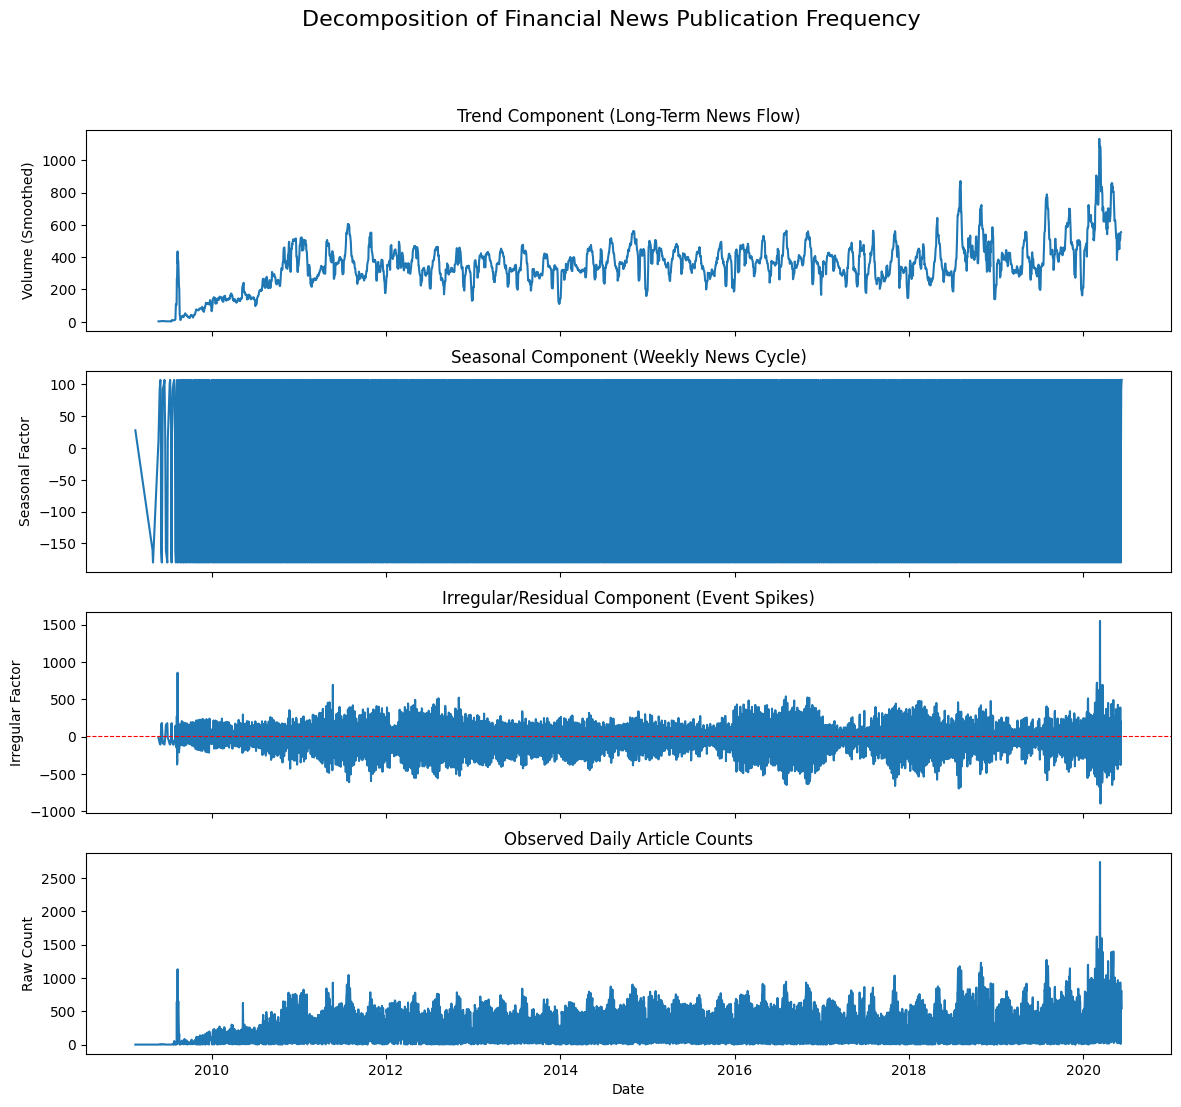

In [ ]:
ig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

if decomposition:
    # 4.1 Trend (Long-term growth/decline)
    axes[0].plot(decomposition.trend)
    axes[0].set_title('Trend Component (Long-Term News Flow)')
    axes[0].set_ylabel('Volume (Smoothed)')

    # 4.2 Seasonality (Weekly Pattern)
    axes[1].plot(decomposition.seasonal)
    axes[1].set_title('Seasonal Component (Weekly News Cycle)')
    axes[1].set_ylabel('Seasonal Factor')

    # 4.3 Residual/Irregular (Event Correlation Spikes)
    axes[2].plot(decomposition.resid)
    axes[2].set_title('Irregular/Residual Component (Event Spikes)')
    axes[2].set_ylabel('Irregular Factor')
    axes[2].axhline(y=1.0, color='r', linestyle='--', linewidth=0.8)

    # 4.4 Original Data
    axes[3].plot(decomposition.observed)
    axes[3].set_title('Observed Daily Article Counts')
    axes[3].set_ylabel('Raw Count')
    axes[3].set_xlabel('Date')

    plt.suptitle('Decomposition of Financial News Publication Frequency', fontsize=16)

In [ ]:
decomposition = seasonal_decompose(active_daily_counts, model='additive', period=365)
print("Time Series Decomposition successful.")

Time Series Decomposition successful.


Text(0.5, 0.98, 'Decomposition of Financial News Publication Frequency')

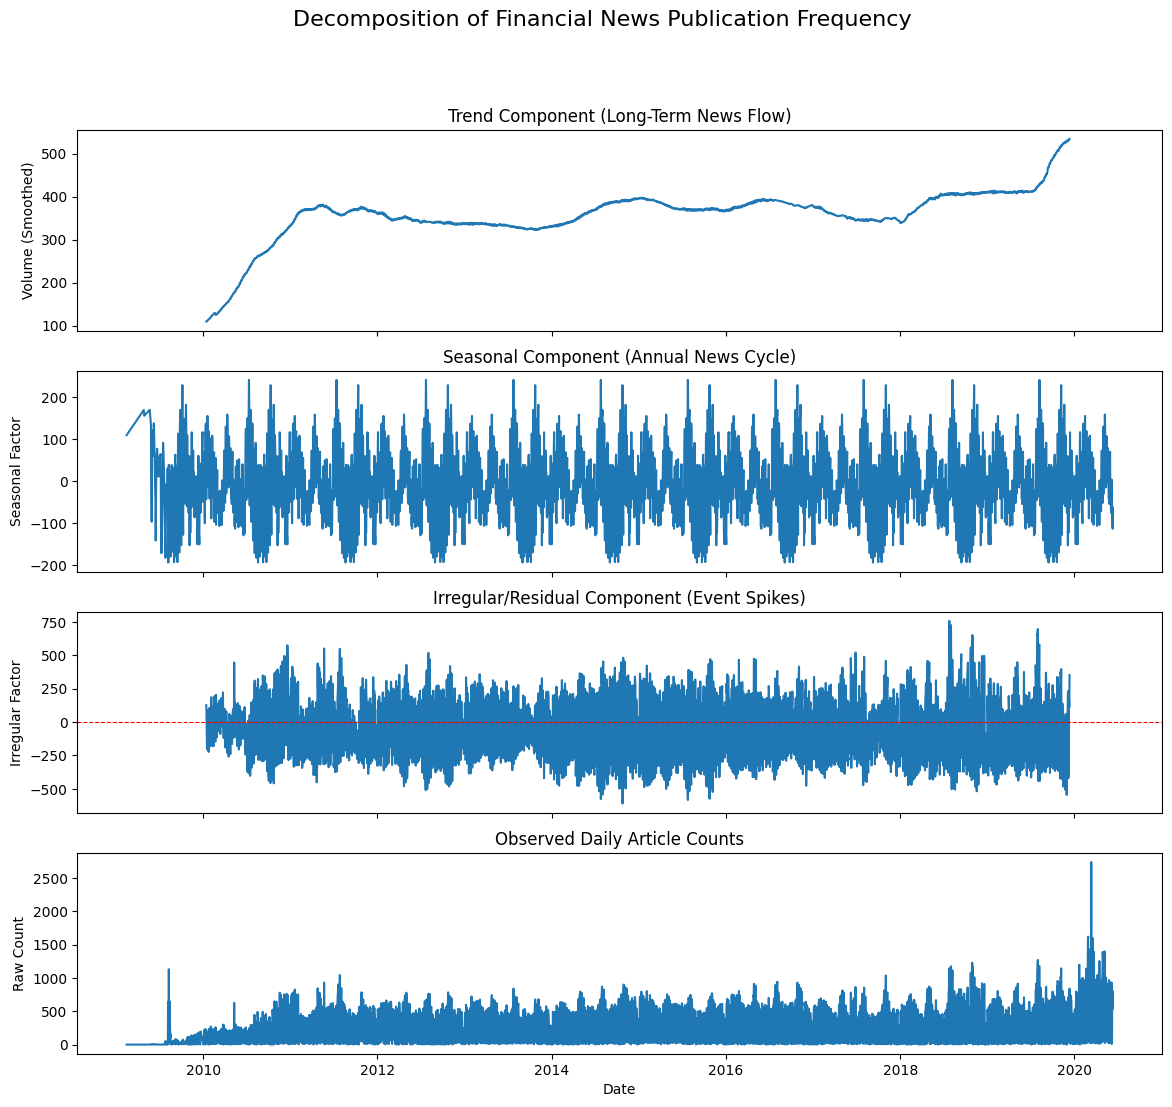

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
# 4.1 Trend (Long-term growth/decline)
axes[0].plot(decomposition.trend)
axes[0].set_title('Trend Component (Long-Term News Flow)')
axes[0].set_ylabel('Volume (Smoothed)')

# 4.2 Seasonality (Annual Pattern)
axes[1].plot(decomposition.seasonal)
axes[1].set_title('Seasonal Component (Annual News Cycle)')
axes[1].set_ylabel('Seasonal Factor')

# 4.3 Residual/Irregular (Event Correlation Spikes)
axes[2].plot(decomposition.resid)
axes[2].set_title('Irregular/Residual Component (Event Spikes)')
axes[2].set_ylabel('Irregular Factor')
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=0.8) # Redline is at 0 for additive model

# 4.4 Original Data
axes[3].plot(decomposition.observed)
axes[3].set_title('Observed Daily Article Counts')
axes[3].set_ylabel('Raw Count')
axes[3].set_xlabel('Date')

plt.suptitle('Decomposition of Financial News Publication Frequency', fontsize=16)

## 4. Publisher Analysis


In [ ]:
# Assuming your publisher column is named 'publisher'
TOP_N = 10

publisher_counts = df['publisher'].value_counts()
print(f"\n--- Top {TOP_N} News Publishers by Volume ---")
print(publisher_counts.nlargest(TOP_N))


--- Top 10 News Publishers by Volume ---
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


In [ ]:
import re

# Function to extract the domain name from an email address
def extract_domain(publisher_name):
    if '@' in publisher_name:
        match = re.search(r'@(.+?)(?:\.\w+)?$', publisher_name)
        if match:
            return match.group(1)
    return publisher_name # Return original name if not an email

# Create a new, normalized publisher column
df['publisher_domain'] = df['publisher'].apply(extract_domain)

print("\n--- Top Publisher Domains (Normalized) ---")
print(df['publisher_domain'].value_counts().nlargest(5))


--- Top Publisher Domains (Normalized) ---
publisher_domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64


In [ ]:
# Assuming Step 2 successfully created 'df['publisher_domain']'

# 1. Pivot the table to show Topic Counts per Publisher Domain
topic_distribution_by_publisher = df.groupby('publisher_domain')['nmf_topic_id'].value_counts().unstack(fill_value=0)

# 2. Add a Total Count column (the crucial step for sorting)
topic_distribution_by_publisher['Total_Count'] = topic_distribution_by_publisher.sum(axis=1)

# 3. Sort the DataFrame by the new Total_Count column and select the top 5
# Now we can use .nlargest() on the Total_Count column specifically.
top_5_publishers_by_topic = topic_distribution_by_publisher.nlargest(5, columns='Total_Count')

# 4. Display the result (showing the Total Count and the first 5 Topic Counts)
print("\n--- Topic Distribution by Publisher (Top 5 Domains) ---")

# Display all topic columns for the top 5 publishers
# We drop the 'Total_Count' column for cleaner presentation of topic specialization, but keep it for reference if needed
print(top_5_publishers_by_topic.drop(columns='Total_Count').iloc[:, :5])


--- Topic Distribution by Publisher (Top 5 Domains) ---
nmf_topic_id           0      1      2      3      4
publisher_domain                                    
Paul Quintaro      69156   5945  15116  43083  45809
Lisa Levin           266  54367  56422    604   2172
Benzinga Newsdesk  10756  25313   5317   8472  52749
Charles Gross       6271   4540   5799  11648  31032
Monica Gerson        242  23665   7888   3127   4572


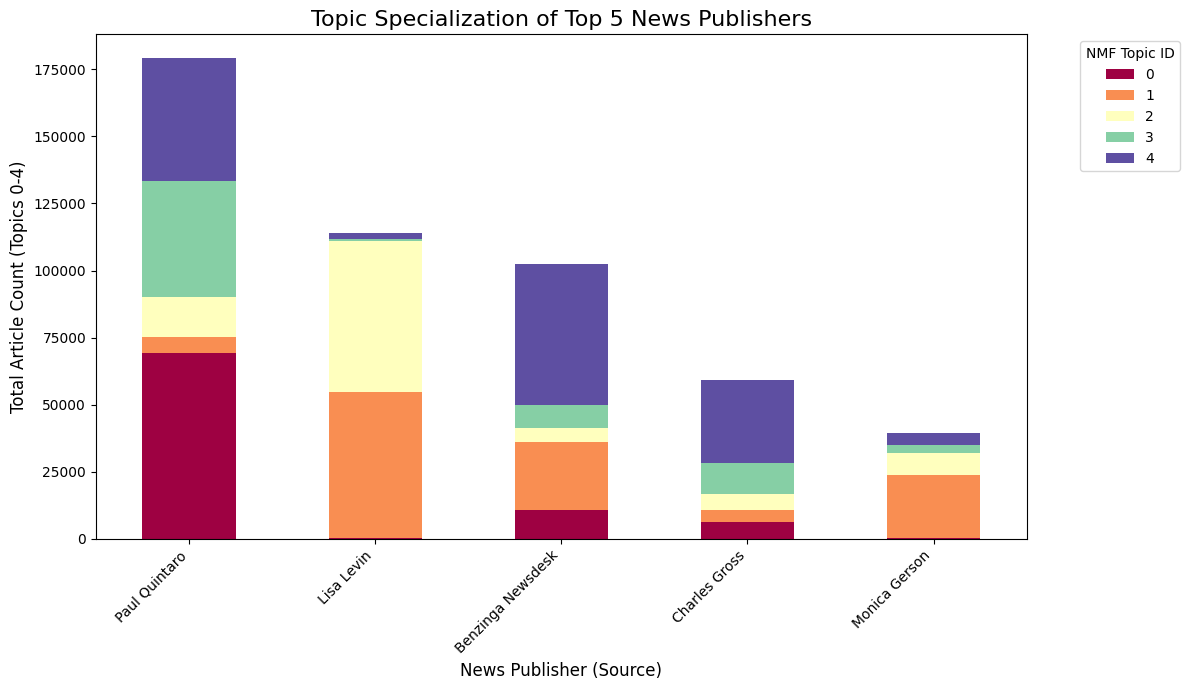

In [ ]:
topic_columns = top_5_publishers_by_topic.columns[:-1].tolist()
topics_to_plot = topic_columns[:5]
plot_df = top_5_publishers_by_topic[topics_to_plot]

# Generate the stacked bar chart
plt.figure(figsize=(12, 7))
plot_df.plot(kind='bar', stacked=True, colormap='Spectral', ax=plt.gca())

plt.title('Topic Specialization of Top 5 News Publishers', fontsize=16)
plt.xlabel('News Publisher (Source)', fontsize=12)
plt.ylabel('Total Article Count (Topics 0-4)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='NMF Topic ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [ ]:

top_5_publishers_by_topic

nmf_topic_id,0,1,2,3,4,5,6,7,8,9,Total_Count
publisher_domain,,,,,,,,,,,
Paul Quintaro,69156,5945,15116,43083,45809,16553,3974,7818,6523,14396,228373
Lisa Levin,266,54367,56422,604,2172,545,22270,20790,403,29140,186979
Benzinga Newsdesk,10756,25313,5317,8472,52749,25831,3881,11255,2514,4396,150484
Charles Gross,6271,4540,5799,11648,31032,2079,3539,3896,20446,7482,96732
Monica Gerson,242,23665,7888,3127,4572,1729,22591,1322,596,16648,82380


# Sentiment Analysis

In [ ]:
# --- 1. Handling Null Values ---

print("\n--- 1. Null Value Check (Before Cleaning) ---")
print(df.isnull().sum())
print(df.shape[0])

# We focus on the 'headline' column since it's used for sentiment analysis.
# Strategy: Drop rows where the 'headline' is null, as we can't analyze empty text.
df.dropna(subset=['headline'], inplace=True)

print("\n--- Null Value Check (After Cleaning) ---")
print(f"Remaining rows after dropping null headlines: {df.shape[0]}")

In [ ]:
# --- 2. Duplicate and Consistency Checks ---

# Check for duplicate rows across all columns
duplicate_count = df.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates, keeping the first instance
    df.drop_duplicates(inplace=True)
    print(f"Rows remaining after dropping duplicates: {df.shape[0]}")

# Ensure the 'headline' column is string type before analysis
df['headline'] = df['headline'].astype(str)

In [ ]:
df['TextBlob_Sentiment'] = df['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['TextBlob_Category'] = df['TextBlob_Sentiment'].apply(sentiment_category)
print(df[['headline','TextBlob_Sentiment','TextBlob_Category']])

In [ ]:
9# Count number of headlines in each category
sentiment_counts = df['TextBlob_Category'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Sentiment Analysis of Headlines (TextBlob)")
plt.ylabel("Number of Headlines")
plt.xlabel("Sentiment Category")
plt.show()